In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
#training data
train_data = np.load('train_data.npz')
X_train = train_data['X']
y_train = train_data['y']

#test data
test_data = np.load('test_images.npz')
X_test = test_data['X']

#shapes
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Test images shape: {X_test.shape}")


Training images shape: (2000, 128, 128)
Training masks shape: (2000, 128, 128)
Test images shape: (2000, 128, 128)


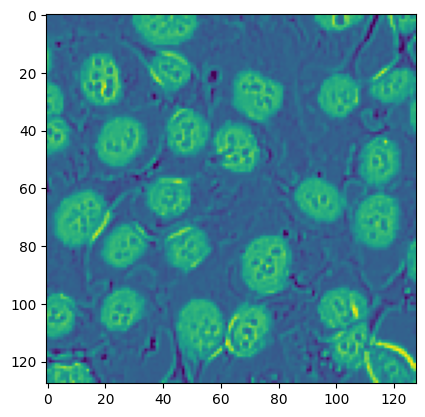

In [3]:
#display image
i = 18
plt.imshow(X_train[i] / 255 + 0.5 * y_train[i])
plt.show()

In [41]:
class CellDataset(Dataset):
    def __init__(self, images, masks=None):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32) / 255.0
        image = image.reshape((1, image.shape[0], image.shape[1]))
        image = torch.tensor(image, dtype=torch.float32)

        if self.masks is not None:
            mask = self.masks[idx].astype(np.float32)
            mask = mask.reshape((1, mask.shape[0], mask.shape[1]))
            mask = torch.tensor(mask, dtype=torch.float32)
            return image, mask

        return image


In [1]:
#dataset and dataloader for training
dataset_train = CellDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

#dataset and dataloader for test
dataset_test = CellDataset(X_test)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

x_batch, y_batch = next(iter(dataloader_train))
print(x_batch.shape)
print(y_batch.shape)

x_test_batch = next(iter(dataloader_test))
print(x_test_batch.shape)


NameError: name 'CellDataset' is not defined

In [62]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        #Downward
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = torch.nn.Conv2d(256, 512, kernel_size=3, padding=1)

        #Upward
        self.upconv3 = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5 = torch.nn.Conv2d(768, 256, kernel_size=3, padding=1)  # 512 + 256
        self.upconv2 = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6 = torch.nn.Conv2d(384, 128, kernel_size=3, padding=1)  # 256 + 128
        self.upconv1 = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7 = torch.nn.Conv2d(192, 64, kernel_size=3, padding=1)   # 128 + 64

        self.final_conv = torch.nn.Conv2d(64, 1, kernel_size=1)

        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        #Downward
        x1 = self.relu(self.conv1(x))
        x2 = self.maxpool(x1)
        x2 = self.relu(self.conv2(x2))
        x3 = self.maxpool(x2)
        x3 = self.relu(self.conv3(x3))
        x4 = self.maxpool(x3)
        x4 = self.relu(self.conv4(x4))

        #Upward
        x5 = self.upconv3(x4)
        x5 = torch.cat((x5, x3), dim=1)
        x5 = self.relu(self.conv5(x5))
        x6 = self.upconv2(x5)
        x6 = torch.cat((x6, x2), dim=1)
        x6 = self.relu(self.conv6(x6))
        x7 = self.upconv1(x6)
        x7 = torch.cat((x7, x1), dim=1)
        x7 = self.relu(self.conv7(x7))

        return self.final_conv(x7)

In [25]:
softmax=torch.nn.Softmax()

Epoch 1/300, Train Loss: 0.4019
Epoch 2/300, Train Loss: 0.2732
Epoch 3/300, Train Loss: 0.2195
Epoch 4/300, Train Loss: 0.1951
Epoch 5/300, Train Loss: 0.1798
Epoch 6/300, Train Loss: 0.1685
Epoch 7/300, Train Loss: 0.1631
Epoch 8/300, Train Loss: 0.1575
Epoch 9/300, Train Loss: 0.1548
Epoch 10/300, Train Loss: 0.1562
Epoch 11/300, Train Loss: 0.1482
Epoch 12/300, Train Loss: 0.1445
Epoch 13/300, Train Loss: 0.1426
Epoch 14/300, Train Loss: 0.1396
Epoch 15/300, Train Loss: 0.1364
Epoch 16/300, Train Loss: 0.1336
Epoch 17/300, Train Loss: 0.1310
Epoch 18/300, Train Loss: 0.1298
Epoch 19/300, Train Loss: 0.1261
Epoch 20/300, Train Loss: 0.1244
Epoch 21/300, Train Loss: 0.1218
Epoch 22/300, Train Loss: 0.1194
Epoch 23/300, Train Loss: 0.1183
Epoch 24/300, Train Loss: 0.1156
Epoch 25/300, Train Loss: 0.1137
Epoch 26/300, Train Loss: 0.1114
Epoch 27/300, Train Loss: 0.1110
Epoch 28/300, Train Loss: 0.1092
Epoch 29/300, Train Loss: 0.1062
Epoch 30/300, Train Loss: 0.1052
Epoch 31/300, Train

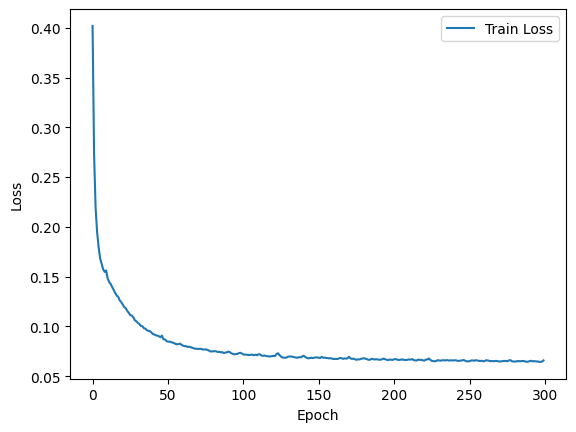

In [69]:
model = UNet()
device = torch.device('cuda')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
loss_fun = torch.nn.BCEWithLogitsLoss()

#training loop
num_epochs = 300
train_losses = []

for ep in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in dataloader_train:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = loss_fun(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(dataloader_train))
    print(f'Epoch {ep+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}')

#plot
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [70]:
from scipy import ndimage
import cv2

def count_cells(mask, threshold=0.5):
    mask = mask > threshold
    labeled_mask, num_cells = ndimage.label(mask)
    return num_cells

cell_counts = []
model.eval()
with torch.no_grad():
    for x_batch in dataloader_test:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.sigmoid(outputs)

        for i in range(preds.size(0)):
            pred_mask = preds[i].cpu().numpy().squeeze()
            num_cells = count_cells(pred_mask)
            cell_counts.append(num_cells)


#sample submission file for index
sample_submission = pd.read_csv('sample_submission.csv')

#dataFrame for submission
submission_df = pd.DataFrame({
    'index': sample_submission['index'],
    'count': cell_counts
})

#CSV file
submission_df.to_csv('submission.csv', index=False)

print(submission_df.head())


   index  count
0      0      4
1      1     11
2      2     10
3      3     10
4      4     11


In [71]:
from google.colab import files

# Download the submission.csv file
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>